<a href="https://colab.research.google.com/github/AP-047/RClass-Classification-by-Rational-Approximation/blob/main/notebooks/1D_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**GPU Set-up**

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


**Set Locale to UTF-8**

In [2]:
!apt-get install -y locales
!locale-gen en_US.UTF-8
!update-locale LANG=en_US.UTF-8

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
locales is already the newest version (2.35-0ubuntu3.8).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Generating locales (this might take a while)...
  en_US.UTF-8... done
Generation complete.


**Upgrade setuptools and pip**

In [3]:
!pip install -U setuptools pip

**Install CuPy for CUDA 12.2**

In [4]:
!pip install cupy-cuda12x

**Sample code to check GPU usage**

In [5]:
import cupy as cp

# Check initial GPU memory usage
mempool = cp.get_default_memory_pool()
print("Initial GPU memory usage (bytes):", mempool.used_bytes())

# Create a large CuPy array on the GPU
size = 10**7  # Adjust size as needed to stress GPU
x = cp.random.random(size, dtype=cp.float32)

# Perform some GPU operations
y = x ** 9999999  # Square the elements
z = y.sum()  # Sum the elements

# Sync to ensure GPU computations are complete
cp.cuda.Device().synchronize()

# Check GPU memory usage after operations
print("Used GPU memory after computations (bytes):", mempool.used_bytes())

# Output the result of computation
print("Sum of squares:", z.get())  # Transfer result to CPU (NumPy)

Initial GPU memory usage (bytes): 0
Used GPU memory after computations (bytes): 120000512
Sum of squares: 0.01725622091216212


**Test cuda**

In [6]:
import cupy as cp

# Check GPU memory usage
mempool = cp.get_default_memory_pool()
print("Used memory (bytes):", mempool.used_bytes())

Used memory (bytes): 120000512


**Check GPU memory usage dynamically**

In [7]:
import cupy as cp

# Allocate a large array
x = cp.random.random((10**8,), dtype=cp.float32)  # Large array to stress GPU

# Check GPU memory usage
mempool = cp.get_default_memory_pool()
print("Used GPU memory (bytes):", mempool.used_bytes())

# Perform computations
y = x ** 2
z = cp.sum(y)

# Sync and check memory usage again
cp.cuda.Device().synchronize()
print("Used GPU memory after computations (bytes):", mempool.used_bytes())

Used GPU memory (bytes): 520000512
Used GPU memory after computations (bytes): 880001024


**Ensure CuPy is using the CUDA backend**

In [8]:
# Check CUDA runtime version
print("CUDA runtime version:", cp.cuda.runtime.runtimeGetVersion())

CUDA runtime version: 12020


**Confirm GPU utilization**

In [9]:
# !LC_ALL=C.UTF-8 nvidia-smi

**Training**

Number of Iterations: 27
z Values in all Iterations: [50.0, 25.0, 12.5, 6.25, 3.125, 1.5625, 0.78125, 0.390625, 0.1953125, 0.09765625, 0.048828125, 0.0244140625, 0.01220703125, 0.006103515625, 0.0030517578125, 0.00152587890625, 0.000762939453125, 0.0003814697265625, 0.00019073486328125, 9.5367431640625e-05, 4.76837158203125e-05, 2.384185791015625e-05, 1.1920928955078125e-05, 5.9604644775390625e-06, 2.9802322387695312e-06, 1.4901161193847656e-06, 7.450580596923828e-07]
Optimal z (Maximum Deviation): 7.450580596923828e-07


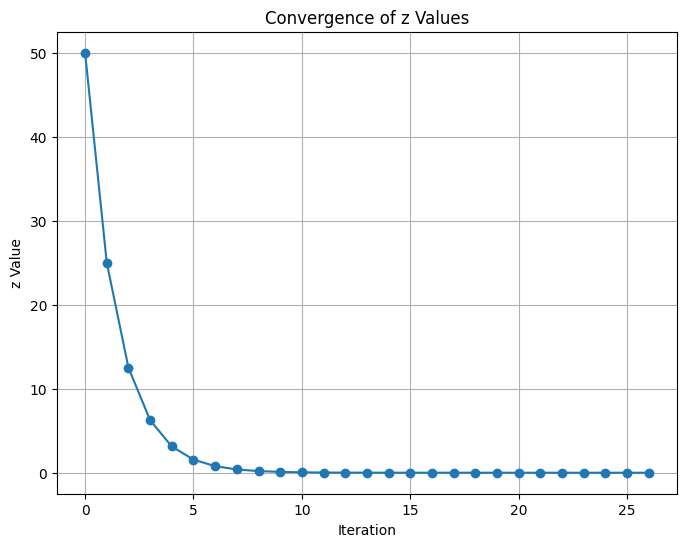

Optimized Coefficients (Numerator α): [5.78036938e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.67114035e-04 0.00000000e+00 6.96735086e-03 9.13303356e-05
 9.59465186e-03 1.96022933e-05 2.52611224e-03 0.00000000e+00
 9.87251509e-05]
Optimized Coefficients (Denominator β): [1.37941074e-06 1.46054829e-05 1.16046586e-04 2.99614264e-04
 3.15309166e-03 1.07584315e-03 1.01475294e-02 6.67957363e-04
 6.08079698e-03 6.89331796e-05 6.61614639e-04 6.12290202e-07
 6.39087130e-06]
Optimal θ: 7.673135465749539e-08


In [15]:
import cupy as cp
from scipy.optimize import linprog
import matplotlib.pyplot as plt

# Target function
def target_function(x):
    return cp.abs(x - 0.1)

# Rational function | r(x) = (α_0 + α_1*x + ...)/(β_0 + β_1*x + ...)
def rational_function(x, alpha, beta):
    # Numerator polynomial
    numerator = sum(alpha[i] * x**i for i in range(len(alpha)))
    # Denominator polynomial
    denominator = sum(beta[i] * x**i for i in range(len(beta)))
    return numerator / denominator

delta = 1e-6 # a small +ve value for constraint_3

# Feasibility check function
def check_feasibility_and_compute_coefficients(z, x_data, y_data, degree):
    num_data_points = len(x_data)
    num_coefficients = degree + 1  # Number of coefficients for num & den

    # Construct the G(x) & H(x) polynomials
    # Numerator polynomial
    G = cp.array([[x**i for i in range(num_coefficients)] for x in x_data])
    # Denominator polynomial
    H = cp.array([[x**i for i in range(num_coefficients)] for x in x_data])

    # Construct constraints for Ax <= b
    A = []
    b = []

    for i in range(num_data_points):
        f_plus_z = y_data[i] + z    #UB(X)
        f_minus_z = y_data[i] - z   #LB

        # Constraint 1: (f(xi) - z) * β^T H(xi) - α^T G(xi) ≤ θ
        # (-G(xi))αT + (f(xi) - z).H(xi)βT + (-1)θ ≤ 0
        constraint_1 = cp.zeros(2 * num_coefficients + 1)
        # (1) Coefficients of α
        constraint_1[0:num_coefficients] = -G[i]
        # (2) Coefficients of β
        constraint_1[num_coefficients:2 * num_coefficients] = (f_minus_z) * H[i]
        # (3) Coefficient of θ (last element)
        constraint_1[-1] = -1
        A.append(constraint_1)
        b.append(0)

        # Constraint 2: α^T G(xi) - (f(xi) - z) * β^T H(xi) ≤ θ
        # G(xi).αT + (-1)(f(xi) - z).H(xi)βT + (-1)θ ≤ 0
        constraint_2 = cp.zeros(2 * num_coefficients + 1)
        # (1) Coefficients of α
        constraint_2[0:num_coefficients] = G[i]
        # (2) Coefficients of β
        constraint_2[num_coefficients:2 * num_coefficients] = -(f_plus_z) * H[i]
        # (3) Coefficient of θ (last element)
        constraint_2[-1] = -1
        A.append(constraint_2)
        b.append(0)

        # Constraint 3: β^T H(x) ≥ δ
        # (0)α^T + (-H(x)) β^T + (0)θ ≤ -δ
        constraint_3 = cp.zeros(2 * num_coefficients + 1)
        # Coefficients of β
        constraint_3[num_coefficients:2 * num_coefficients] = -H[i]
        A.append(constraint_3)
        b.append(-delta)

    # print(f"A: {A[0]}")

    # Convert CuPy arrays to NumPy arrays for SciPy
    A = cp.asnumpy(cp.array(A))
    b = cp.asnumpy(cp.array(b))

    # print(f"A: {A[0]}")
    # print(f"len(A[0]): {len(A[0])}")
    # print(f"len(b): {len(b)}")

    #for linprog API -
    # Objective function to minimize θ
    c = cp.asnumpy(cp.zeros(2 * num_coefficients + 1))
    c[-1] = 1  # Only θ has a coefficient in the objective function

    # Solve the linear programming problem
    result = linprog(c, A_ub=A, b_ub=b, method="highs")

    # Check feasibility and return results
    if result.success:
        alpha_coefficients = result.x[:num_coefficients]
        beta_coefficients = result.x[num_coefficients:2 * num_coefficients]
        theta = result.x[-1]
        return True, alpha_coefficients, beta_coefficients, theta
    else:
        return False, None, None, None

# Bisection loop
def bisection_loop(x_data, y_data, degree, uL, uH, precision):
    optimal_alpha, optimal_beta, optimal_theta = None, None, None
    z_values = []

    while uH - uL > precision:
        z = (uL + uH) / 2
        z_values.append(z)
        feasible, alpha_coefficients, beta_coefficients, theta = check_feasibility_and_compute_coefficients(z, x_data, y_data, degree)

        if feasible:
            uH = z
            optimal_alpha, optimal_beta, optimal_theta = alpha_coefficients, beta_coefficients, theta
        else:
            uL = z

    return uH, optimal_alpha, optimal_beta, optimal_theta, z_values

# Main execution
if __name__ == "__main__":
    # Data setup
    degree = 12  # Polynomial degree
    x_data = cp.linspace(-3, 3, 100)  # Discretized data points
    y_data = target_function(x_data)  # Target values

    # Initial coefficients for the rational function
    # alpha_initial = [5, 3, 2]  # Coefficients of numerator
    # beta_initial = [7, 4, 3]   # Coefficients of denominator

    # Bisection parameters
    uL = 0  # Initial lower bound
    uH = 100  # Initial upper bound
    precision = 1e-6  # Precision threshold

    # Run bisection loop
    optimal_z, optimal_alpha, optimal_beta, optimal_theta, z_values = bisection_loop(x_data, y_data, degree, uL, uH, precision)

    # Print results
    print(f"Number of Iterations: {len(z_values)}")
    print(f"z Values in all Iterations: {z_values}")
    print(f"Optimal z (Maximum Deviation): {optimal_z}")

    # Plot convergence of z values
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(z_values)), z_values, marker='o', linestyle='-')
    plt.xlabel("Iteration")
    plt.ylabel("z Value")
    plt.title("Convergence of z Values")
    plt.grid(True)
    plt.show()

    print(f"Optimized Coefficients (Numerator α): {optimal_alpha}")
    print(f"Optimized Coefficients (Denominator β): {optimal_beta}")
    print(f"Optimal θ: {optimal_theta}")

**Testing**

In [ ]:
# import matplotlib.pyplot as plt

# # Close-up
# def plot_functions(target_function, rational_function, alpha, beta, x_range):
#     # Generate points for the plot
#     x_test = cp.linspace(x_range[0], x_range[1], 900)  # Use CuPy for GPU computations
#     y_target = target_function(x_test)  # Compute the target function values
#     y_rational = cp.array([rational_function(x, alpha, beta) for x in x_test])  # Compute rational function values

#     # Convert CuPy arrays to NumPy for plotting
#     x_test = cp.asnumpy(x_test)
#     y_target = cp.asnumpy(y_target)
#     y_rational = cp.asnumpy(y_rational)

#     # Plot the functions
#     plt.figure(figsize=(8, 6))
#     plt.plot(x_test, y_target, label="Target Function", color="blue", linewidth=2)
#     plt.plot(x_test, y_rational, label="Rational Function Approximation", color="red", linestyle="--", linewidth=2)
#     plt.scatter(cp.asnumpy(x_data), cp.asnumpy(y_data), label="Data Points", color="purple", marker="o")
#     plt.xlabel("x")
#     plt.ylabel("f(x)")
#     plt.title("Target Function vs Rational Function Approximation")
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# # Main execution for plotting
# if __name__ == "__main__":
#     # Test points range for plotting
#     x_range = [-4, 4]

#     # Call the plotting function
#     plot_functions(target_function, rational_function, optimal_alpha, optimal_beta, x_range)

# # Bigger range
# def plot_functions(target_function, rational_function, alpha, beta, x_range):
#     # Generate points for the plot
#     x_test = cp.linspace(x_range[0], x_range[1], 900)  # Use CuPy for GPU computations
#     y_target = target_function(x_test)  # Compute the target function values
#     y_rational = cp.array([rational_function(x, alpha, beta) for x in x_test])  # Compute rational function values

#     # Convert CuPy arrays to NumPy for plotting
#     x_test = cp.asnumpy(x_test)
#     y_target = cp.asnumpy(y_target)
#     y_rational = cp.asnumpy(y_rational)

#     # Plot the functions
#     plt.figure(figsize=(8, 6))
#     plt.plot(x_test, y_target, label="Target Function", color="blue", linewidth=2)
#     plt.plot(x_test, y_rational, label="Rational Function Approximation", color="red", linestyle="--", linewidth=2)
#     # plt.scatter(cp.asnumpy(x_data), cp.asnumpy(y_data), label="Data Points", color="purple", marker="o")
#     plt.xlabel("x")
#     plt.ylabel("f(x)")
#     plt.title("Target Function vs Rational Function Approximation")
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# # Main execution for plotting
# if __name__ == "__main__":
#     # Test points range for plotting
#     x_range = [-8, 8]

#     # Call the plotting function
#     plot_functions(target_function, rational_function, optimal_alpha, optimal_beta, x_range)

**Diff. Datapoints**

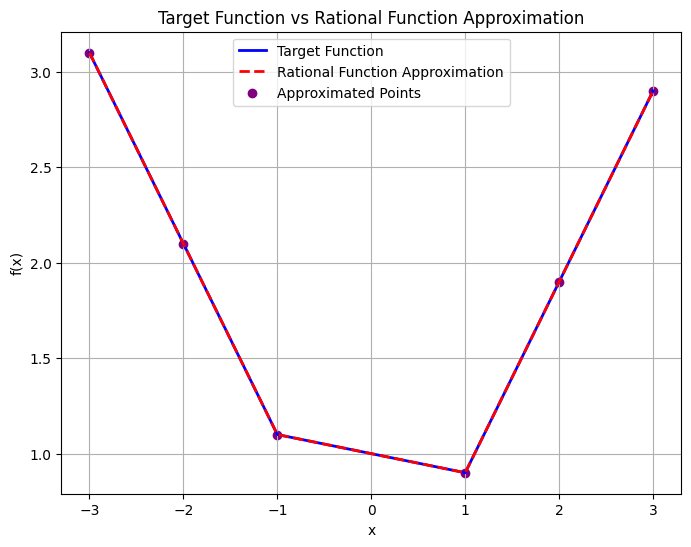

y_target: [3.1 2.1 1.1 0.9 1.9 2.9]
y_rational: [3.09999925 2.10000023 1.09999263 0.89999869 1.89999955 2.89999925]
abs(y_target - y_rational): [7.45941873e-07 2.30657063e-07 7.36766057e-06 1.30949232e-06
 4.48099613e-07 7.45881271e-07]


In [38]:
import matplotlib.pyplot as plt

# Close-up
def plot_functions(target_function, rational_function, alpha, beta, x_test_values):
    # Generate points for the plot
    x_test = cp.array(x_test_values)  # Use the provided x_test_values
    y_target = target_function(x_test)  # Compute the target function values
    y_rational = cp.array([rational_function(x, alpha, beta) for x in x_test])  # Compute rational function values

    # Convert CuPy arrays to NumPy for plotting
    x_test = cp.asnumpy(x_test)
    y_target = cp.asnumpy(y_target)
    y_rational = cp.asnumpy(y_rational)

    # Plot the functions
    plt.figure(figsize=(8, 6))
    plt.plot(x_test, y_target, label="Target Function", color="blue", linewidth=2)
    plt.plot(x_test, y_rational, label="Rational Function Approximation", color="red", linestyle="--", linewidth=2)
    plt.scatter(x_test, y_rational, label="Approximated Points", color="purple", marker="o") #Scatter plot for approximated points
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.title("Target Function vs Rational Function Approximation")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"y_target: {y_target}")
    print(f"y_rational: {y_rational}")
    print(f"abs(y_target - y_rational): {abs(y_target - y_rational)}")

# Main execution for plotting
if __name__ == "__main__":

    # Datapoints outside of the training dataset (-3 tp 3, 100)
    # x_test_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    # x_test_values = [12, 18, 20, 34, 40, 55]

    # Datapoints inside of the training dataset
    # x_test_values = [-2.1, -1.7, -1.2, -0.6, 0.8, 1.6, 2.1, 2.8]
    x_test_values = [-3, -2, -1, 1, 2, 3]


    # Call the plotting function
    plot_functions(target_function, rational_function, optimal_alpha, optimal_beta, x_test_values)